# Movie Recommendation Machine Learning Project Using K-Means

### The data science workflow for this project has 4 main steps:

    1. Loading the data
    2. Exploratory data analysis (EDA) – Data cleaning and exploration
          Cleaning the data
          Visualizing the data
          Feature engineering
    3. Data modelling
          Population segmentation using unsupervised clustering
    4. Drawing conclusions from our modelling
          Accessing the KMeans model attributes


In [38]:
import os
import boto3
import io
import sagemaker

import pandas as pd
import numpy as np
import mxnet as mx
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sagemaker import get_execution_role
from sagemaker import KMeans

## Step 1 - Loading The Data

**I experienced EC2 Instance resource issues reading the title.akas.tsv file described below:  
ml.t2.medium failed  
ml.t2.large worked**

### For the read of the IMDB title.akas.tsv data I am only interested in the titleId and the language columns so all other columns will filtered out in the read_csv command.

In [39]:
df_akas = pd.read_csv('https://datasets.imdbws.com/title.akas.tsv.gz', sep='\t', index_col='titleId', usecols = ['titleId','language'])

In [40]:
df_title = pd.read_csv('https://datasets.imdbws.com/title.basics.tsv.gz', sep='\t', index_col='tconst')

In [41]:
df_ratings = pd.read_csv('https://datasets.imdbws.com/title.ratings.tsv.gz', sep='\t', index_col='tconst')

In [42]:
df_akas.head()

,language
titleId,
tt0000001,\N
tt0000001,\N
tt0000001,\N
tt0000001,\N
tt0000001,\N


In [43]:
df_title.head()

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
tconst,,,,,,,,
tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [44]:
df_ratings.head()

,averageRating,numVotes
tconst,,
tt0000001,5.6,1662
tt0000002,6.1,204
tt0000003,6.5,1376
tt0000004,6.2,123
tt0000005,6.2,2164


In [45]:
df_akas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24182312 entries, tt0000001 to tt9916856
Data columns (total 1 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   language  object
dtypes: object(1)
memory usage: 369.0+ MB


In [46]:
df_title.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7347968 entries, tt0000001 to tt9916880
Data columns (total 8 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   titleType       object
 1   primaryTitle    object
 2   originalTitle   object
 3   isAdult         int64 
 4   startYear       object
 5   endYear         object
 6   runtimeMinutes  object
 7   genres          object
dtypes: int64(1), object(7)
memory usage: 504.5+ MB


In [47]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1092100 entries, tt0000001 to tt9916778
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   averageRating  1092100 non-null  float64
 1   numVotes       1092100 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 25.0+ MB


In [48]:
df_akas.shape

(24182312, 1)

In [49]:
df_title.shape

(7347968, 8)

In [50]:
df_ratings.shape

(1092100, 2)

## Step 2 - Exploratory data analysis (EDA) – Data cleaning and exploration

### For this project the final dataset will be filtered to only contain English language, non-adult movies.  In addition, since the goal is to provide movie recommendations I want to provide good recommendations.  Therefore, only movies with a rating over 7 will be recommended, but movies also have to have a sufficient number of votes to get recommended.  I am considering 1,000 votes as the minimum to be recommended, but I will evaluate that threshold below and it may be adjusted to ensure there are enough movies in the recommendation pool.

### I have a hypothesis about the ratings data that I hope to prove via visualization.  My hypothesis is that movies with more votes have higher ratings because they are popular and since they are popular they get more votes.

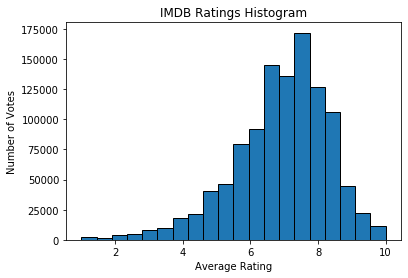

In [51]:
plt.hist(df_ratings['averageRating'], bins=20, edgecolor='black')
plt.title('IMDB Ratings Histogram')
plt.xlabel('Average Rating')
plt.ylabel('Number of Votes')
plt.show()

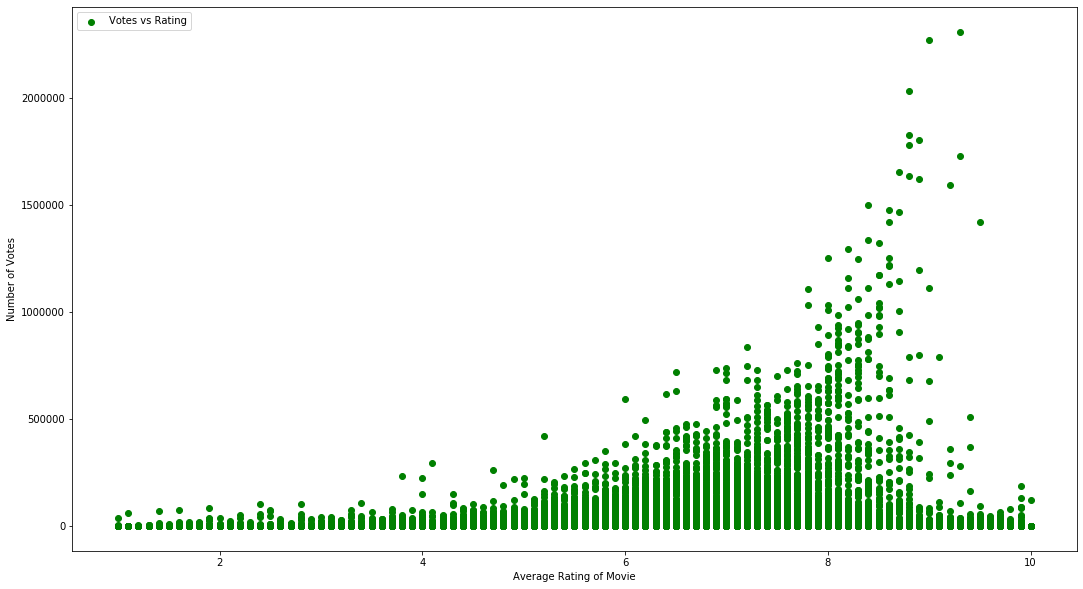

In [52]:
plt.figure(figsize = (18,10))
plt.scatter(df_ratings['averageRating'], df_ratings['numVotes'], c='g', label='Votes vs Rating')
plt.xlabel('Average Rating of Movie')
plt.ylabel('Number of Votes')
plt.legend(loc='upper left')
plt.show()

Text(0, 0.5, 'Number of Votes')

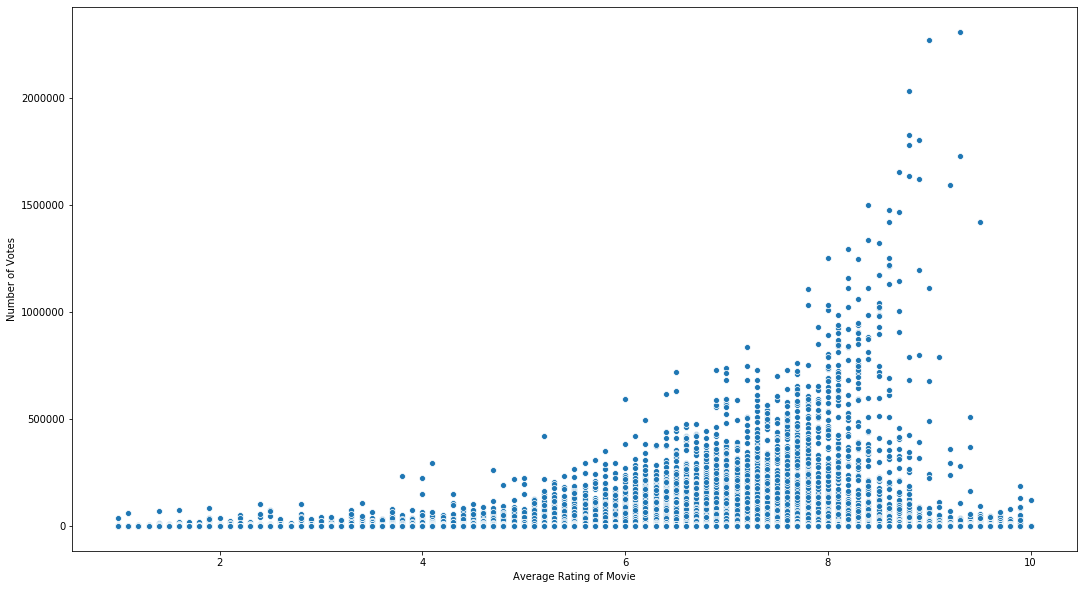

In [53]:
plt.figure(figsize = (18,10))
sns.scatterplot(x = df_ratings['averageRating'], y = df_ratings['numVotes'])
plt.xlabel('Average Rating of Movie')
plt.ylabel('Number of Votes')

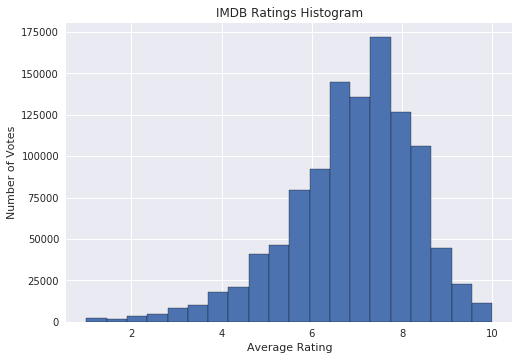

In [54]:
with plt.style.context('seaborn'):
    plt.hist(df_ratings['averageRating'], bins=20, edgecolor = 'black')
    plt.title('IMDB Ratings Histogram')
    plt.xlabel('Average Rating')
    plt.ylabel('Number of Votes')

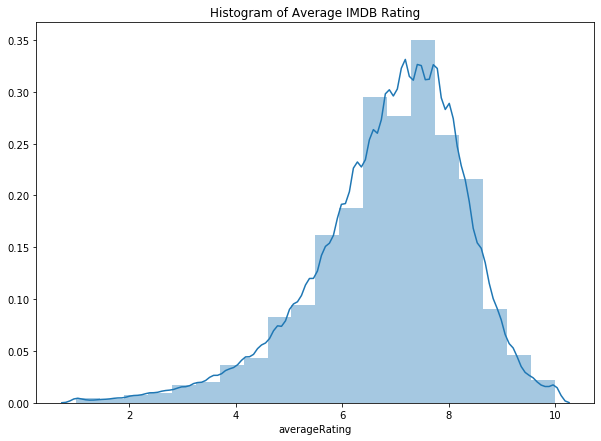

In [55]:
plt.figure(figsize = (10,7))
ax=sns.distplot(df_ratings['averageRating'], bins=20)
title="Histogram of Average IMDB Rating"
ax.set_title(title, fontsize=12)
plt.show()

**Merge the ratings and title dataframes.  
The following merge is similar to a SQL INNER JOIN**

In [56]:
df_rt = pd.merge(df_ratings, df_title, left_index=True, right_index=True)

In [57]:
df_rt.shape

(1092100, 10)

In [58]:
df_rt.head()

,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
tconst,,,,,,,,,,
tt0000001,5.6,1662,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
tt0000002,6.1,204,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
tt0000003,6.5,1376,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
tt0000004,6.2,123,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
tt0000005,6.2,2164,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


#### Select the rows where isAdult is equal to 0 and overwrite the dataframe.

In [59]:
df_rt.isAdult.unique()

array([   0,    1, 2020, 2014])

In [60]:
df_rt = df_rt.query('isAdult == 0')

In [61]:
df_rt.isAdult.unique()

array([0])

#### Select the rows where titleType is equal to movie and overwrite the dataframe.

In [62]:
df_rt.titleType.unique()

array(['short', 'movie', 'tvShort', 'tvSeries', 'tvMovie', 'tvEpisode',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame'], dtype=object)

In [63]:
df_rt.shape

(1073452, 10)

In [64]:
df_rt = df_rt.query('titleType == "movie"')

In [65]:
df_rt.titleType.unique()

array(['movie'], dtype=object)

In [66]:
df_rt.shape

(251454, 10)

#### Drop the titleType, originalTitle, isAdult, startYear, endYear and runtimeMinutes columns.

In [67]:
df_rt.drop(['titleType', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes'], axis = 1, inplace=True)

In [68]:
df_rt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251454 entries, tt0000009 to tt9916538
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   averageRating  251454 non-null  float64
 1   numVotes       251454 non-null  int64  
 2   primaryTitle   251454 non-null  object 
 3   genres         251454 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 9.6+ MB


#### Now, it is time to validate the rating data.  Is it reasonable to only consider movies with more than 1,000 votes and a rating greater than 7?

In [69]:
df_rt.query('numVotes > 1000')

,averageRating,numVotes,primaryTitle,genres
tconst,,,,
tt0002130,7.1,2293,Dante's Inferno,"Adventure,Drama,Fantasy"
tt0002844,7.0,1963,Fantômas: In the Shadow of the Guillotine,"Crime,Drama"
tt0003037,7.0,1365,Fantomas: The Man in Black,"Crime,Drama"
tt0003165,7.0,1063,Fantômas: The Dead Man Who Killed,"Crime,Drama,Mystery"
tt0003419,6.5,1799,The Student of Prague,"Drama,Fantasy,Horror"
...,...,...,...,...
tt9877170,6.5,7595,Malang,"Action,Crime,Drama"
tt9882084,7.8,1906,Chasing Happiness,"Biography,Documentary,Music"
tt9894470,6.1,4772,VFW,"Action,Crime,Horror"


In [70]:
df_rt.query('numVotes > 500')

,averageRating,numVotes,primaryTitle,genres
tconst,,,,
tt0000574,6.1,598,The Story of the Kelly Gang,"Biography,Crime,Drama"
tt0002130,7.1,2293,Dante's Inferno,"Adventure,Drama,Fantasy"
tt0002423,6.8,762,Passion,"Biography,Drama,Romance"
tt0002844,7.0,1963,Fantômas: In the Shadow of the Guillotine,"Crime,Drama"
tt0003014,7.1,965,Ingeborg Holm,Drama
...,...,...,...,...
tt9904802,4.8,987,Enemy Lines,War
tt9905462,8.5,576,Pengalila,Drama
tt9906644,6.8,530,Manoharam,"Comedy,Drama"


In [71]:
df_rt.query('averageRating > 7')

,averageRating,numVotes,primaryTitle,genres
tconst,,,,
tt0001475,7.5,13,Amor fatal,"Drama,Romance"
tt0001498,7.7,6,The Battle of Trafalgar,War
tt0002130,7.1,2293,Dante's Inferno,"Adventure,Drama,Fantasy"
tt0002305,7.4,16,Life of Villa,"Documentary,War"
tt0002637,7.2,5,Arizona,Western
...,...,...,...,...
tt9914254,7.9,7,A Cherry Tale,Documentary
tt9914642,8.2,26,Albatross,Documentary
tt9914644,8.3,63,9/11: Escape from the Towers,Documentary


#### Based on the above three queries I have decided to lower the vote threshold to 500 and keep the rating threshold at 7.

In [72]:
df_rt = df_rt.query('numVotes > 500')

In [73]:
df_rt = df_rt.query('averageRating > 7')

In [74]:
df_rt.shape

(12023, 4)

#### Basically we now have a DataFrame that contains English movie titles with their ratings and genres

In [75]:
df = df_rt.copy()

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12023 entries, tt0002130 to tt9911196
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   averageRating  12023 non-null  float64
 1   numVotes       12023 non-null  int64  
 2   primaryTitle   12023 non-null  object 
 3   genres         12023 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 469.6+ KB


In [77]:
list(df.columns)

['averageRating', 'numVotes', 'primaryTitle', 'genres']

In [78]:
df.head()

,averageRating,numVotes,primaryTitle,genres
tconst,,,,
tt0002130,7.1,2293,Dante's Inferno,"Adventure,Drama,Fantasy"
tt0003014,7.1,965,Ingeborg Holm,Drama
tt0003740,7.1,3114,Cabiria,"Adventure,Drama,History"
tt0006206,7.3,4213,Les vampires,"Action,Adventure,Crime"
tt0006864,7.7,14046,Intolerance: Love's Struggle Throughout the Ages,"Drama,History"


In [79]:
df.shape

(12023, 4)

Saving a Pandas Dataframe as a CSV

df.to_csv('mergeOfTitleAndRatings.csv')

In [80]:
df.genres.unique()

array(['Adventure,Drama,Fantasy', 'Drama', 'Adventure,Drama,History',
       'Action,Adventure,Crime', 'Drama,History', 'Adventure,Crime',
       'Drama,War', 'Comedy,War', 'Comedy', 'Drama,Romance',
       'Drama,Horror,War', 'Fantasy,Horror,Mystery', 'Comedy,Fantasy',
       'Fantasy,Horror', 'Adventure,Romance,Western',
       'Crime,Drama,Horror', 'Comedy,Drama,Horror', 'Drama,Romance,War',
       'Comedy,Drama,Family', 'Drama,Fantasy,Horror',
       'Drama,Fantasy,Thriller', 'Drama,History,Romance',
       'Comedy,Romance', 'Crime,Mystery,Thriller',
       'Documentary,Fantasy,History', 'Documentary',
       'Adventure,Family,Romance', 'Drama,Horror,Romance',
       'Comedy,Romance,Thriller', 'Action,Comedy,Thriller',
       'Adventure,Comedy,Family', 'Drama,Romance,Thriller',
       'Adventure,Drama,Mystery', 'History,Romance,Western',
       'Action,Comedy,Romance', 'Sci-Fi', 'Adventure,Family,Fantasy',
       'Adventure,Animation,Family', 'Drama,History,Thriller',
       'Comed

In [81]:
df.genres.unique().shape

(555,)

#### One Hot Encoding (OHE) logic used below came from  
https://stackoverflow.com/questions/47786822/how-do-you-one-hot-encode-columns-with-a-list-of-strings-as-values

In [82]:
df.head()

,averageRating,numVotes,primaryTitle,genres
tconst,,,,
tt0002130,7.1,2293,Dante's Inferno,"Adventure,Drama,Fantasy"
tt0003014,7.1,965,Ingeborg Holm,Drama
tt0003740,7.1,3114,Cabiria,"Adventure,Drama,History"
tt0006206,7.3,4213,Les vampires,"Action,Adventure,Crime"
tt0006864,7.7,14046,Intolerance: Love's Struggle Throughout the Ages,"Drama,History"


In [83]:
df.genres

tconst
tt0002130    Adventure,Drama,Fantasy
tt0003014                      Drama
tt0003740    Adventure,Drama,History
tt0006206     Action,Adventure,Crime
tt0006864              Drama,History
                      ...           
tt9886872             Comedy,Romance
tt9894440               Comedy,Drama
tt9900782            Action,Thriller
tt9905462                      Drama
tt9911196               Comedy,Drama
Name: genres, Length: 12023, dtype: object

In [84]:
ohe_genres_df = df.genres.str.get_dummies(',').add_prefix('genre_')

In [85]:
ohe_genres_df

,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,...,genre_Mystery,genre_News,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Thriller,genre_War,genre_Western,genre_\N
tconst,,,,,,,,,,,,,,,,,,,,,
tt0002130,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
tt0003014,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0003740,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0006206,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0006864,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9886872,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
tt9894440,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt9900782,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


#### Drop the genre_Adult column, if it exists, because this project is not using adult movies.

In [ ]:
#ohe_genres_df.drop(['genre_Adult'], axis = 1, inplace=True)

#### Drop the genre_\N column

In [87]:
ohe_genres_df.drop(['genre_\\N'], axis = 1, inplace=True)

In [88]:
ohe_genres_df.head()

,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,...,genre_Musical,genre_Mystery,genre_News,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Thriller,genre_War,genre_Western
tconst,,,,,,,,,,,,,,,,,,,,,
tt0002130,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
tt0003014,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0003740,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0006206,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0006864,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
ohe_genres_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12023 entries, tt0002130 to tt9911196
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   genre_Action       12023 non-null  int64
 1   genre_Adventure    12023 non-null  int64
 2   genre_Animation    12023 non-null  int64
 3   genre_Biography    12023 non-null  int64
 4   genre_Comedy       12023 non-null  int64
 5   genre_Crime        12023 non-null  int64
 6   genre_Documentary  12023 non-null  int64
 7   genre_Drama        12023 non-null  int64
 8   genre_Family       12023 non-null  int64
 9   genre_Fantasy      12023 non-null  int64
 10  genre_Film-Noir    12023 non-null  int64
 11  genre_History      12023 non-null  int64
 12  genre_Horror       12023 non-null  int64
 13  genre_Music        12023 non-null  int64
 14  genre_Musical      12023 non-null  int64
 15  genre_Mystery      12023 non-null  int64
 16  genre_News         12023 non-null  int64
 17  genre

#### Add these one hot encoded genres to the df DataFrame

In [90]:
df = pd.concat([df, ohe_genres_df], axis=1, sort=False)

In [91]:
df.head()

,averageRating,numVotes,primaryTitle,genres,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,...,genre_Musical,genre_Mystery,genre_News,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Thriller,genre_War,genre_Western
tconst,,,,,,,,,,,,,,,,,,,,,
tt0002130,7.1,2293,Dante's Inferno,"Adventure,Drama,Fantasy",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0003014,7.1,965,Ingeborg Holm,Drama,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0003740,7.1,3114,Cabiria,"Adventure,Drama,History",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0006206,7.3,4213,Les vampires,"Action,Adventure,Crime",1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
tt0006864,7.7,14046,Intolerance: Love's Struggle Throughout the Ages,"Drama,History",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Drop the genres column because it is now redundant with the addition of the one hot encoded genres feature

In [92]:
df.drop(['genres'], axis = 1, inplace=True)

In [93]:
df.head()

,averageRating,numVotes,primaryTitle,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,...,genre_Musical,genre_Mystery,genre_News,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Thriller,genre_War,genre_Western
tconst,,,,,,,,,,,,,,,,,,,,,
tt0002130,7.1,2293,Dante's Inferno,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0003014,7.1,965,Ingeborg Holm,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0003740,7.1,3114,Cabiria,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0006206,7.3,4213,Les vampires,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
tt0006864,7.7,14046,Intolerance: Love's Struggle Throughout the Ages,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12023 entries, tt0002130 to tt9911196
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   averageRating      12023 non-null  float64
 1   numVotes           12023 non-null  int64  
 2   primaryTitle       12023 non-null  object 
 3   genre_Action       12023 non-null  int64  
 4   genre_Adventure    12023 non-null  int64  
 5   genre_Animation    12023 non-null  int64  
 6   genre_Biography    12023 non-null  int64  
 7   genre_Comedy       12023 non-null  int64  
 8   genre_Crime        12023 non-null  int64  
 9   genre_Documentary  12023 non-null  int64  
 10  genre_Drama        12023 non-null  int64  
 11  genre_Family       12023 non-null  int64  
 12  genre_Fantasy      12023 non-null  int64  
 13  genre_Film-Noir    12023 non-null  int64  
 14  genre_History      12023 non-null  int64  
 15  genre_Horror       12023 non-null  int64  
 16  genre_Music    

**Time to merge the titleId and language from the title.akas.tsv file  
First, test for duplicate indexes in the df_akas DataFrame  
Second, select the English movies**

In [95]:
df.shape

(12023, 27)

In [96]:
df_akas.shape

(24182312, 1)

In [97]:
df_akas.language.unique()

array(['\\N', 'ja', 'sv', 'en', 'tr', 'es', 'sr', 'cs', 'sk', 'fr', 'fa',
       'bg', 'ca', 'nl', 'qbn', 'pt', 'ru', 'uk', 'qbp', 'ar', 'cmn',
       'rn', 'bs', 'de', 'hi', 'yi', 'qbo', 'ka', 'hr', 'sl', 'he', 'tg',
       'kk', 'da', 'el', 'fi', 'it', 'be', 'gsw', 'gl', 'eu', 'yue', 'az',
       'ms', 'pl', 'mr', 'uz', 'th', 'ta', 'af', 'la', 'hy', 'ur', 'bn',
       'te', 'ml', 'lt', 'mk', 'et', 'lv', 'tl', 'id', 'gd', 'ga', 'cy',
       'qal', 'gu', 'kn', 'ro', 'hu', 'pa', 'wo', 'no', 'is', 'sq', 'vi',
       'zh', 'ps', 'zu', 'nqo', 'sd', 'xh', 'mi', 'ku', 'rm', 'su', 'jv',
       'prs', 'ky', 'fro', 'ko', 'haw', 'mn', 'lo', 'my', 'am', 'qac',
       'ne', 'myv', 'br', 'iu', 'st', 'tn', 'cr'], dtype=object)

In [98]:
df_akas.query('index =="tt0060196"')

,language
titleId,
tt0060196,\N
tt0060196,sv
tt0060196,tr
tt0060196,sv
tt0060196,\N
...,...
tt0060196,sr
tt0060196,\N
tt0060196,\N


#### Select the rows where language is equal to en and overwrite the dataframe.

In [99]:
df_akas = df_akas.query('language == "en"')

In [100]:
df_akas.shape

(244161, 1)

Test for duplicates

In [101]:
df_akas.query('index =="tt0060196"')

,language
titleId,
tt0060196,en
tt0060196,en
tt0060196,en
tt0060196,en
tt0060196,en
tt0060196,en


In [102]:
df_akas.language.unique()

array(['en'], dtype=object)

#### Remove duplicate indexes from the df_akas DataFrame

In [103]:
df_akas = df_akas.groupby(df_akas.index).first()

In [104]:
df_akas.shape

(185629, 1)

Test again for duplicates

In [105]:
df_akas.query('index =="tt0060196"')

,language
titleId,
tt0060196,en


#### The following merge is similar to a SQL INNER JOIN

In [106]:
df = pd.merge(df_akas, df, left_index=True, right_index=True)

In [107]:
df.head()

,language,averageRating,numVotes,primaryTitle,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,...,genre_Musical,genre_Mystery,genre_News,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Thriller,genre_War,genre_Western
tt0003740,en,7.1,3114,Cabiria,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0006864,en,7.7,14046,Intolerance: Love's Struggle Throughout the Ages,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0008663,en,7.4,1532,A Man There Was,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
tt0009893,en,7.2,1656,The Oyster Princess,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
tt0009968,en,7.3,9352,Broken Blossoms,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [108]:
df.rename_axis("titleId", inplace=True)

In [109]:
df.query('primaryTitle =="The Good, the Bad and the Ugly"')

,language,averageRating,numVotes,primaryTitle,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,...,genre_Musical,genre_Mystery,genre_News,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Thriller,genre_War,genre_Western
titleId,,,,,,,,,,,,,,,,,,,,,
tt0060196,en,8.8,679562,"The Good, the Bad and the Ugly",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [110]:
df.query('index =="tt0060196"')

,language,averageRating,numVotes,primaryTitle,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,...,genre_Musical,genre_Mystery,genre_News,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Thriller,genre_War,genre_Western
titleId,,,,,,,,,,,,,,,,,,,,,
tt0060196,en,8.8,679562,"The Good, the Bad and the Ugly",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [111]:
df.drop(['language'], axis = 1, inplace=True)

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8859 entries, tt0003740 to tt9911196
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   averageRating      8859 non-null   float64
 1   numVotes           8859 non-null   int64  
 2   primaryTitle       8859 non-null   object 
 3   genre_Action       8859 non-null   int64  
 4   genre_Adventure    8859 non-null   int64  
 5   genre_Animation    8859 non-null   int64  
 6   genre_Biography    8859 non-null   int64  
 7   genre_Comedy       8859 non-null   int64  
 8   genre_Crime        8859 non-null   int64  
 9   genre_Documentary  8859 non-null   int64  
 10  genre_Drama        8859 non-null   int64  
 11  genre_Family       8859 non-null   int64  
 12  genre_Fantasy      8859 non-null   int64  
 13  genre_Film-Noir    8859 non-null   int64  
 14  genre_History      8859 non-null   int64  
 15  genre_Horror       8859 non-null   int64  
 16  genre_Music     

In [113]:
df.shape

(8859, 27)

### Feature engineering

#### Make an independent copy of the dataframe that doesn't have its index modified to be used at the end for recommendations

In [114]:
df_titles = df.copy()

In [115]:
# Remove all columns between column name 'genre_Action' to 'genre_Western' 
df_titles.drop(df.loc[:, 'genre_Action':'genre_Western'].columns, axis = 1, inplace=True) 

In [116]:
df_titles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8859 entries, tt0003740 to tt9911196
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   averageRating  8859 non-null   float64
 1   numVotes       8859 non-null   int64  
 2   primaryTitle   8859 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 276.8+ KB


In [117]:
df_titles.shape

(8859, 3)

#### Modify the index to contain a concatenation of the existing index and the primaryTitle and leave all columns containing numerical data.

In [118]:
df.index=df.index + "-" + df['primaryTitle']

In [119]:
df

,averageRating,numVotes,primaryTitle,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,...,genre_Musical,genre_Mystery,genre_News,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Thriller,genre_War,genre_Western
tt0003740-Cabiria,7.1,3114,Cabiria,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0006864-Intolerance: Love's Struggle Throughout the Ages,7.7,14046,Intolerance: Love's Struggle Throughout the Ages,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0008663-A Man There Was,7.4,1532,A Man There Was,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
tt0009893-The Oyster Princess,7.2,1656,The Oyster Princess,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0009968-Broken Blossoms,7.3,9352,Broken Blossoms,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9886872-Munthiri Monchan,8.1,994,Munthiri Monchan,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
tt9894440-Min pappa Marianne,7.1,679,Min pappa Marianne,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt9900782-Kaithi,8.5,9859,Kaithi,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
tt9905462-Pengalila,8.5,576,Pengalila,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
df.drop(['primaryTitle'],axis=1,inplace=True)

In [121]:
df

,averageRating,numVotes,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_Musical,genre_Mystery,genre_News,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Thriller,genre_War,genre_Western
tt0003740-Cabiria,7.1,3114,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
tt0006864-Intolerance: Love's Struggle Throughout the Ages,7.7,14046,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
tt0008663-A Man There Was,7.4,1532,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
tt0009893-The Oyster Princess,7.2,1656,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0009968-Broken Blossoms,7.3,9352,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9886872-Munthiri Monchan,8.1,994,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
tt9894440-Min pappa Marianne,7.1,679,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
tt9900782-Kaithi,8.5,9859,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
tt9905462-Pengalila,8.5,576,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Check that each genre column has two values (zero and one).  If it only has array([0]) then that genre column can be deleted

In [122]:
for col in df.columns:
    if col.startswith( 'genre_' ):
        if (df[col].unique() == [0]).all():
            print(f'Recommend dropping the {col} column because it only contains zeros.')
        else:
            #print(f'Recommend keeping the {col} column because it contains both zeros and ones')
            pass

Recommend dropping the genre_Short column because it only contains zeros.


#### Based on the above results the genre_Short column can be dropped.

In [124]:
df.drop(['genre_Short'], axis=1, inplace=True)

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8859 entries, tt0003740-Cabiria to tt9911196-The Marriage Escape
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   averageRating      8859 non-null   float64
 1   numVotes           8859 non-null   int64  
 2   genre_Action       8859 non-null   int64  
 3   genre_Adventure    8859 non-null   int64  
 4   genre_Animation    8859 non-null   int64  
 5   genre_Biography    8859 non-null   int64  
 6   genre_Comedy       8859 non-null   int64  
 7   genre_Crime        8859 non-null   int64  
 8   genre_Documentary  8859 non-null   int64  
 9   genre_Drama        8859 non-null   int64  
 10  genre_Family       8859 non-null   int64  
 11  genre_Fantasy      8859 non-null   int64  
 12  genre_Film-Noir    8859 non-null   int64  
 13  genre_History      8859 non-null   int64  
 14  genre_Horror       8859 non-null   int64  
 15  genre_Music        8859 non-null   i

In [126]:
df.shape

(8859, 25)

**Data Scaling** – Standardize the scaling of the numerical columns in order to use any distance based analytical methods so that we can compare the relative distances between different feature columns. Use minmaxscaler to transform the numerical columns so that they also fall between 0 and 1.

In [127]:
scaler=MinMaxScaler()
df_movies_scaled=pd.DataFrame(scaler.fit_transform(df))
df_movies_scaled.columns=df.columns
df_movies_scaled.index=df.index

In [128]:
df_movies_scaled.describe()

,averageRating,numVotes,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_Music,genre_Musical,genre_Mystery,genre_News,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War,genre_Western
count,8859.000000,8859.000000,8859.000000,8859.000000,8859.000000,8859.000000,8859.000000,8859.000000,8859.000000,8859.000000,...,8859.000000,8859.000000,8859.000000,8859.000000,8859.000000,8859.000000,8859.000000,8859.000000,8859.000000,8859.000000
mean,0.175076,0.021510,0.144937,0.098318,0.053618,0.082966,0.268653,0.158483,0.082628,0.692968,...,0.034993,0.023705,0.055988,0.002258,0.164353,0.022463,0.020205,0.097415,0.047522,0.013771
std,0.154196,0.063294,0.352058,0.297761,0.225275,0.275847,0.443284,0.365214,0.275334,0.461289,...,0.183772,0.152136,0.229912,0.047463,0.370616,0.148192,0.140710,0.296539,0.212765,0.116547
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.038462,0.000450,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.153846,0.001885,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.269231,0.009740,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [129]:
df_movies_scaled.head()

,averageRating,numVotes,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_Music,genre_Musical,genre_Mystery,genre_News,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War,genre_Western
tt0003740-Cabiria,0.000000,0.001133,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0006864-Intolerance: Love's Struggle Throughout the Ages,0.230769,0.005874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0008663-A Man There Was,0.115385,0.000447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
tt0009893-The Oyster Princess,0.038462,0.000501,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0009968-Broken Blossoms,0.076923,0.003838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Step 3 - Data modelling

In [130]:
df_movies_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8859 entries, tt0003740-Cabiria to tt9911196-The Marriage Escape
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   averageRating      8859 non-null   float64
 1   numVotes           8859 non-null   float64
 2   genre_Action       8859 non-null   float64
 3   genre_Adventure    8859 non-null   float64
 4   genre_Animation    8859 non-null   float64
 5   genre_Biography    8859 non-null   float64
 6   genre_Comedy       8859 non-null   float64
 7   genre_Crime        8859 non-null   float64
 8   genre_Documentary  8859 non-null   float64
 9   genre_Drama        8859 non-null   float64
 10  genre_Family       8859 non-null   float64
 11  genre_Fantasy      8859 non-null   float64
 12  genre_Film-Noir    8859 non-null   float64
 13  genre_History      8859 non-null   float64
 14  genre_Horror       8859 non-null   float64
 15  genre_Music        8859 non-null   f

In [131]:
train_data = df_movies_scaled.values.astype('float32')

#### Call and define the hyperparameters of the KMeans model. The Kmeans algorithm allows for the setting of how many clusters to identify.

In [132]:
role = get_execution_role()
bucket_name = 'bg-sagemaker-bucket-us-east-1'
num_clusters = 15
kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path='s3://'+ bucket_name +'/kmeans-movie-titles/',              
                k=num_clusters)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


#### Next, train the model on the training data.  Can take several minutes.

In [133]:
%%time
kmeans.fit(kmeans.record_set(train_data))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-11-18 16:47:26 Starting - Starting the training job...
2020-11-18 16:47:29 Starting - Launching requested ML instances......
2020-11-18 16:48:45 Starting - Preparing the instances for training......
2020-11-18 16:49:44 Downloading - Downloading input data...
2020-11-18 16:50:01 Training - Downloading the training image...
2020-11-18 16:50:52 Uploading - Uploading generated training model
2020-11-18 16:50:52 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/18/2020 16:50:43 INFO 140232207255360] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloy

Training seconds: 68
Billable seconds: 68
CPU times: user 643 ms, sys: 12.1 ms, total: 655 ms
Wall time: 3min 42s


#### Deploy the model and pass in the original training set to get the labels for each entry. This will produce which cluster each movie belongs to.  Can take several minutes.

In [134]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-----------------------!CPU times: user 385 ms, sys: 9.93 ms, total: 395 ms
Wall time: 11min 33s


In [135]:
train_data.shape

(8859, 25)

#### Maximum payload size for endpoint invocation = 6 MB (https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateTransformJob.html#sagemaker-CreateTransformJob-request-MaxPayloadInMB).  In a previous iteration of this Notebook, the train_data Dataframe was too large and, therefore, the train_data was split or a 413 Request Entity Too Large error was produced.

#### In the next six lines some commands are commented out in case the size of the dataframe is too large.

In [136]:
#train_data1 = train_data[0:40000]
#train_data2 = train_data[40000:]

In [137]:
#train_data1.shape

In [138]:
#train_data2.shape

In [139]:
%%time
result=kmeans_predictor.predict(train_data)
#result1=kmeans_predictor.predict(train_data1)
#result2=kmeans_predictor.predict(train_data2)

CPU times: user 537 ms, sys: 0 ns, total: 537 ms
Wall time: 2.05 s


In [140]:
#result = result1 + result2

In [141]:
len(result)

8859

#### Breakdown of cluster counts and the distribution of clusters.

In [142]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
pd.DataFrame(cluster_labels)[0].value_counts()

2.0     1885
10.0     884
1.0      883
11.0     863
3.0      747
8.0      569
6.0      560
14.0     498
9.0      386
13.0     327
5.0      325
0.0      299
12.0     269
7.0      247
4.0      117
Name: 0, dtype: int64

## Drawing conclusions from our modelling

### Accessing the KMeans model attributes

In [143]:
job_name='kmeans-2020-11-18-16-47-26-718'
model_key = "kmeans-movie-titles/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')
2304
Kmeans_model_params = mx.ndarray.load('model_algo-1')

**There is 1 set of model parameters that is contained within the KMeans model.**  

**Cluster Centroid Locations:** The location of the centers of each cluster identified by the Kmeans algorithm.

In [144]:
cluster_centroids=pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns=df_movies_scaled.columns
cluster_centroids

,averageRating,numVotes,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_Music,genre_Musical,genre_Mystery,genre_News,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War,genre_Western
0,0.147245,0.034206,2.970297e-01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.980198,0.000000e+00,0.607261,...,3.725290e-09,3.300328e-03,3.300332e-03,0.000000e+00,3.300324e-03,0.000000e+00,0.000000e+00,0.960396,0.000000e+00,0.000000e+00
1,0.159811,0.013118,5.017105e-02,0.027366,0.004561,4.218929e-02,2.980232e-08,0.001140,2.280500e-03,0.936146,...,9.122007e-03,6.157354e-02,3.762828e-02,0.000000e+00,9.920182e-01,1.140251e-02,6.841505e-03,0.015964,5.701254e-02,1.938426e-02
2,0.179822,0.014916,4.926115e-03,0.081773,0.032512,2.758620e-02,4.926085e-03,0.001970,1.871921e-02,0.971921,...,3.891626e-02,1.970443e-02,5.418720e-02,1.477833e-03,7.881775e-03,2.216749e-02,1.527094e-02,0.001478,9.852201e-04,1.970443e-02
3,0.167468,0.017052,1.263021e-01,0.093750,0.031250,1.041667e-02,9.466145e-01,0.199219,6.510418e-03,0.022135,...,2.083333e-02,6.901041e-02,3.645833e-02,0.000000e+00,1.041666e-02,1.953125e-02,1.041667e-02,0.041667,1.822916e-02,5.208332e-02
4,0.262363,0.002201,-1.490116e-08,0.000000,0.000000,2.946429e-01,1.785715e-02,0.000000,9.910714e-01,0.000000,...,9.999999e-01,8.928575e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.008929,8.928575e-03,0.000000e+00
5,0.163836,0.025375,9.967532e-01,0.224026,0.058442,0.000000e+00,1.298702e-02,0.000000,0.000000e+00,0.902597,...,0.000000e+00,1.623376e-02,3.896104e-02,0.000000e+00,6.493509e-03,2.922078e-02,4.220780e-02,0.000000,7.792208e-02,1.298701e-02
6,0.178600,0.074476,6.159170e-01,0.809689,0.581315,3.460207e-02,2.733564e-01,0.055363,3.725290e-09,0.072664,...,-3.725290e-09,5.190309e-03,1.384083e-02,0.000000e+00,6.920397e-03,1.038062e-01,0.000000e+00,0.031142,7.450581e-09,2.249135e-02
7,0.149292,0.039897,1.008772e-01,0.026316,0.004386,0.000000e+00,4.385966e-02,0.122807,3.725290e-09,0.035088,...,8.771930e-03,0.000000e+00,4.824561e-01,0.000000e+00,2.631579e-02,2.061404e-01,9.313226e-10,0.719298,3.508772e-02,-3.725290e-09
8,0.223198,0.002431,1.742169e-03,0.013937,0.010453,2.369338e-01,2.787456e-02,0.064460,9.895471e-01,0.006969,...,0.000000e+00,1.742158e-03,6.968640e-03,2.961673e-02,0.000000e+00,-3.725290e-09,8.536585e-02,0.005226,5.226480e-02,0.000000e+00
9,0.171512,0.032468,9.883721e-02,0.000000,0.011628,9.534883e-01,2.906978e-03,0.000000,2.034884e-02,0.979651,...,9.011628e-02,1.453488e-02,3.725290e-09,-5.820766e-11,2.906978e-03,-3.725290e-09,1.511628e-01,0.000000,-7.450581e-09,5.813953e-03


#### Plot of a heatmap of the centroids and their location in the transformed feature space. This gives us insight into what characteristics define each cluster. Often with unsupervised learning, results are hard to interpret. 

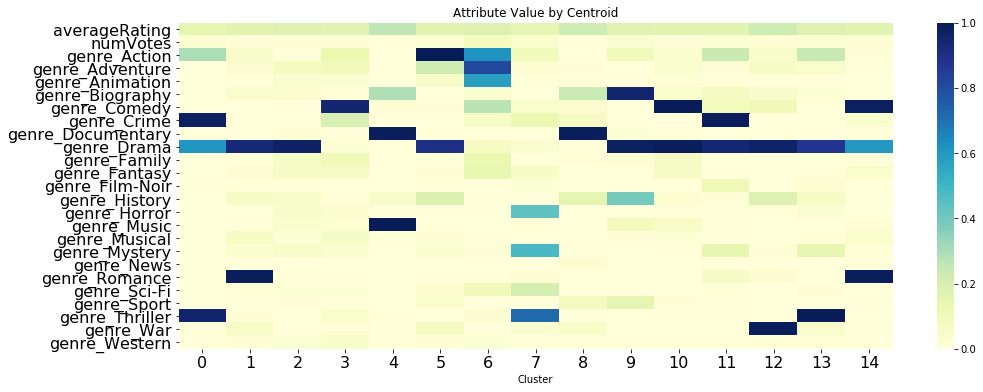

In [145]:
plt.figure(figsize = (16, 6))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

#### Map the cluster labels back to each movie and examine which movies were naturally grouped together.

In [146]:
df_movies_scaled['labels']=list(map(int, cluster_labels))
df_movies_scaled.head(10)

,averageRating,numVotes,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_Musical,genre_Mystery,genre_News,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War,genre_Western,labels
tt0003740-Cabiria,0.000000,0.001133,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
tt0006864-Intolerance: Love's Struggle Throughout the Ages,0.230769,0.005874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
tt0008663-A Man There Was,0.115385,0.000447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12
tt0009893-The Oyster Princess,0.038462,0.000501,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
tt0009968-Broken Blossoms,0.076923,0.003838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
tt0010247-Sir Arne's Treasure,0.038462,0.000299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
tt0010307-J'accuse!,0.230769,0.000408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12
tt0010323-The Cabinet of Dr. Caligari,0.384615,0.024318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
tt0011237-The Golem,0.038462,0.002708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
tt0011607-The Parson's Widow,0.000000,0.000236,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10


In [147]:
df_movies_scaled.shape

(8859, 26)

#### The df_titles datafame is an independent copy of df before index alteration and other feature engineering.

In [149]:
df_titles.shape

(8859, 3)

In [150]:
df_movies_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8859 entries, tt0003740-Cabiria to tt9911196-The Marriage Escape
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   averageRating      8859 non-null   float64
 1   numVotes           8859 non-null   float64
 2   genre_Action       8859 non-null   float64
 3   genre_Adventure    8859 non-null   float64
 4   genre_Animation    8859 non-null   float64
 5   genre_Biography    8859 non-null   float64
 6   genre_Comedy       8859 non-null   float64
 7   genre_Crime        8859 non-null   float64
 8   genre_Documentary  8859 non-null   float64
 9   genre_Drama        8859 non-null   float64
 10  genre_Family       8859 non-null   float64
 11  genre_Fantasy      8859 non-null   float64
 12  genre_Film-Noir    8859 non-null   float64
 13  genre_History      8859 non-null   float64
 14  genre_Horror       8859 non-null   float64
 15  genre_Music        8859 non-null   f

In [151]:
df_titles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8859 entries, tt0003740 to tt9911196
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   averageRating  8859 non-null   float64
 1   numVotes       8859 non-null   int64  
 2   primaryTitle   8859 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 276.8+ KB


In [152]:
df_titles.head()

,averageRating,numVotes,primaryTitle
titleId,,,
tt0003740,7.1,3114,Cabiria
tt0006864,7.7,14046,Intolerance: Love's Struggle Throughout the Ages
tt0008663,7.4,1532,A Man There Was
tt0009893,7.2,1656,The Oyster Princess
tt0009968,7.3,9352,Broken Blossoms


### Test Recommendations

In [153]:
df_movies_scaled['labels']

tt0003740-Cabiria                                              2
tt0006864-Intolerance: Love's Struggle Throughout the Ages     2
tt0008663-A Man There Was                                     12
tt0009893-The Oyster Princess                                  3
tt0009968-Broken Blossoms                                      1
                                                              ..
tt9886872-Munthiri Monchan                                    14
tt9894440-Min pappa Marianne                                  10
tt9900782-Kaithi                                              13
tt9905462-Pengalila                                            2
tt9911196-The Marriage Escape                                 10
Name: labels, Length: 8859, dtype: int64

In [154]:
df_movies_scaled['labels'].unique()

array([ 2, 12,  3,  1,  7, 10, 13,  8, 14,  6, 11,  9,  4,  5,  0])

In [116]:
df_movies_scaled.reset_index()

,index,averageRating,numVotes,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Thriller,genre_War,genre_Western,labels
0,tt0000941-Locura de amor,0.355556,3.035542e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,tt0001122-The Red Inn,0.477778,8.672978e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,tt0001175-Camille,0.533333,7.372031e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,tt0001258-The White Slave Trade,0.533333,3.555921e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,tt0001338-A Night in May,0.477778,4.336489e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86997,tt9910530-Svartklubb,0.500000,4.336489e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
86998,tt9911196-The Marriage Escape,0.744444,4.141347e-04,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
86999,tt9914254-A Cherry Tale,0.766667,8.672978e-07,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
87000,tt9914942-La vida sense la Sara Amat,0.644444,4.379854e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [155]:
df_movies_scaled = df_movies_scaled.rename_axis('idxTitle').reset_index()

In [156]:
df_movies_scaled.head()

,idxTitle,averageRating,numVotes,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,...,genre_Musical,genre_Mystery,genre_News,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War,genre_Western,labels
0,tt0003740-Cabiria,0.000000,0.001133,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,tt0006864-Intolerance: Love's Struggle Through...,0.230769,0.005874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,tt0008663-A Man There Was,0.115385,0.000447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12
3,tt0009893-The Oyster Princess,0.038462,0.000501,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,tt0009968-Broken Blossoms,0.076923,0.003838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [157]:
df_movies_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8859 entries, 0 to 8858
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   idxTitle           8859 non-null   object 
 1   averageRating      8859 non-null   float64
 2   numVotes           8859 non-null   float64
 3   genre_Action       8859 non-null   float64
 4   genre_Adventure    8859 non-null   float64
 5   genre_Animation    8859 non-null   float64
 6   genre_Biography    8859 non-null   float64
 7   genre_Comedy       8859 non-null   float64
 8   genre_Crime        8859 non-null   float64
 9   genre_Documentary  8859 non-null   float64
 10  genre_Drama        8859 non-null   float64
 11  genre_Family       8859 non-null   float64
 12  genre_Fantasy      8859 non-null   float64
 13  genre_Film-Noir    8859 non-null   float64
 14  genre_History      8859 non-null   float64
 15  genre_Horror       8859 non-null   float64
 16  genre_Music        8859 

In [158]:
df_movies_scaled.shape

(8859, 27)

In [159]:
df_movies_scaled[['idx','title']] = df_movies_scaled.idxTitle.str.split("-",1,expand=True)

In [160]:
df_movies_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8859 entries, 0 to 8858
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   idxTitle           8859 non-null   object 
 1   averageRating      8859 non-null   float64
 2   numVotes           8859 non-null   float64
 3   genre_Action       8859 non-null   float64
 4   genre_Adventure    8859 non-null   float64
 5   genre_Animation    8859 non-null   float64
 6   genre_Biography    8859 non-null   float64
 7   genre_Comedy       8859 non-null   float64
 8   genre_Crime        8859 non-null   float64
 9   genre_Documentary  8859 non-null   float64
 10  genre_Drama        8859 non-null   float64
 11  genre_Family       8859 non-null   float64
 12  genre_Fantasy      8859 non-null   float64
 13  genre_Film-Noir    8859 non-null   float64
 14  genre_History      8859 non-null   float64
 15  genre_Horror       8859 non-null   float64
 16  genre_Music        8859 

In [161]:
df_movies_scaled = df_movies_scaled.set_index('idx')

In [162]:
df_movies_scaled.drop(['idxTitle'], axis = 1, inplace=True)

In [163]:
df_movies_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8859 entries, tt0003740 to tt9911196
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   averageRating      8859 non-null   float64
 1   numVotes           8859 non-null   float64
 2   genre_Action       8859 non-null   float64
 3   genre_Adventure    8859 non-null   float64
 4   genre_Animation    8859 non-null   float64
 5   genre_Biography    8859 non-null   float64
 6   genre_Comedy       8859 non-null   float64
 7   genre_Crime        8859 non-null   float64
 8   genre_Documentary  8859 non-null   float64
 9   genre_Drama        8859 non-null   float64
 10  genre_Family       8859 non-null   float64
 11  genre_Fantasy      8859 non-null   float64
 12  genre_Film-Noir    8859 non-null   float64
 13  genre_History      8859 non-null   float64
 14  genre_Horror       8859 non-null   float64
 15  genre_Music        8859 non-null   float64
 16  genre_Musical   

In [164]:
df_movies_scaled.head()

,averageRating,numVotes,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_Mystery,genre_News,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War,genre_Western,labels,title
idx,,,,,,,,,,,,,,,,,,,,,
tt0003740,0.000000,0.001133,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Cabiria
tt0006864,0.230769,0.005874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Intolerance: Love's Struggle Throughout the Ages
tt0008663,0.115385,0.000447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12,A Man There Was
tt0009893,0.038462,0.000501,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,The Oyster Princess
tt0009968,0.076923,0.003838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,Broken Blossoms


#### Merge the labels column of the df_movies_scaled DataFrame with the df_titles DataFrame

In [167]:
df_titles.head()

,averageRating,numVotes,primaryTitle
titleId,,,
tt0003740,7.1,3114,Cabiria
tt0006864,7.7,14046,Intolerance: Love's Struggle Throughout the Ages
tt0008663,7.4,1532,A Man There Was
tt0009893,7.2,1656,The Oyster Princess
tt0009968,7.3,9352,Broken Blossoms


In [171]:
df_titles = pd.merge(df_titles, df_movies_scaled['labels'], left_index=True, right_index=True)

In [172]:
df_titles.head()

,averageRating,numVotes,primaryTitle,labels
titleId,,,,
tt0003740,7.1,3114,Cabiria,2
tt0006864,7.7,14046,Intolerance: Love's Struggle Throughout the Ages,2
tt0008663,7.4,1532,A Man There Was,12
tt0009893,7.2,1656,The Oyster Princess,3
tt0009968,7.3,9352,Broken Blossoms,1


In [174]:
df_titles.query('titleId =="tt0060196"')

,averageRating,numVotes,primaryTitle,labels
titleId,,,,
tt0060196,8.8,679562,"The Good, the Bad and the Ugly",3


In [175]:
df_titles.query('labels == 3')

,averageRating,numVotes,primaryTitle,labels
titleId,,,,
tt0009893,7.2,1656,The Oyster Princess,3
tt0014538,7.1,3992,Three Ages,3
tt0017739,7.1,2693,The Cat and the Canary,3
tt0018841,7.3,572,Dom na Trubnoy,3
tt0020640,7.5,13437,Animal Crackers,3
...,...,...,...,...
tt9420648,7.4,11090,Bala,3
tt9430780,8.4,1066,Bell Bottom,3
tt9484998,7.4,55961,Palm Springs,3


In [176]:
df_titles.query('labels == 3').sample(n=5)

,averageRating,numVotes,primaryTitle,labels
titleId,,,,
tt3013930,7.4,833,Hot Dog,3
tt1119646,7.7,710888,The Hangover,3
tt0425601,7.2,12033,Trailer Park Boys: The Movie,3
tt0095705,7.6,150495,The Naked Gun: From the Files of Police Squad!,3
tt0074937,7.4,33534,Murder by Death,3


In [177]:
df_titles.query('labels == 3').sample(n=15)

,averageRating,numVotes,primaryTitle,labels
titleId,,,,
tt0036891,7.6,4168,Hail the Conquering Hero,3
tt0116426,7.3,8113,The God of Cookery,3
tt0119926,7.4,1561,Postman Blues,3
tt0028708,7.2,1524,Charlie Chan at the Olympics,3
tt0437230,7.1,1167,Horloge biologique,3
tt0052911,7.2,3509,I'm All Right Jack,3
tt0060165,7.3,3814,A Big Hand for the Little Lady,3
tt0082714,7.8,3050,Il marchese del Grillo,3
tt0041546,8.0,34071,Kind Hearts and Coronets,3


In [179]:
df_titles.query('primaryTitle == "Rudy"')

,averageRating,numVotes,primaryTitle,labels
titleId,,,,
tt0108002,7.5,55895,Rudy,9


In [180]:
df_titles.query('labels == 9').sample(n=10)

,averageRating,numVotes,primaryTitle,labels
titleId,,,,
tt0252444,7.4,27215,Rabbit-Proof Fence,9
tt7762982,7.5,1317,Sajjan Singh Rangroot,9
tt0385726,7.2,42693,Glory Road,9
tt0057877,7.8,13464,Becket,9
tt0058886,7.2,6503,The Agony and the Ecstasy,9
tt0274314,8.4,581,Aarilirindhu Aruvathu Varai,9
tt0048729,7.2,4832,To Hell and Back,9
tt0454776,7.4,23773,Amazing Grace,9
tt0108330,7.3,46498,This Boy's Life,9


In [181]:
df_titles.query('primaryTitle == "Cinderella"')

,averageRating,numVotes,primaryTitle,labels
titleId,,,,
tt0042332,7.3,143858,Cinderella,6
tt0168269,7.6,1121,Cinderella,3


In [182]:
df_titles.query('labels == 6').sample(n=10)

,averageRating,numVotes,primaryTitle,labels
titleId,,,,
tt0069436,7.1,5100,Ulzana's Raid,6
tt0070544,7.8,24366,Fantastic Planet,6
tt0965649,7.4,1974,Detective Conan: The Fourteenth Target,6
tt0056059,7.2,11606,Hatari!,6
tt2231208,7.2,1385,Rio 2096: A Story of Love and Fury,6
tt0023238,7.1,10408,The Most Dangerous Game,6
tt0084726,7.7,111636,Star Trek II: The Wrath of Khan,6
tt1690953,7.3,366011,Despicable Me 2,6
tt0398286,7.7,400240,Tangled,6


In [183]:
df_titles.query('primaryTitle == "Dumbo"')

,averageRating,numVotes,primaryTitle,labels
titleId,,,,
tt0033563,7.2,118192,Dumbo,2


In [184]:
df_titles.query('labels == 2').sample(n=12)

,averageRating,numVotes,primaryTitle,labels
titleId,,,,
tt0990404,7.3,3992,Chop Shop,2
tt0997246,7.9,9346,The Song of Sparrows,2
tt0075963,8.4,1465,The Wishing Tree,2
tt4518234,7.8,1509,Cold of Kalandar,2
tt0039941,7.2,2482,The Unsuspected,2
tt0109066,7.5,3396,Vive L'Amour,2
tt0057363,7.5,1874,The Insect Woman,2
tt0425235,7.3,2498,We Shall Overcome,2
tt0049902,8.3,18757,A Man Escaped,2


In [185]:
df_titles.query('primaryTitle == "Mary Poppins"')

,averageRating,numVotes,primaryTitle,labels
titleId,,,,
tt0058331,7.8,155797,Mary Poppins,3


In [186]:
df_titles.query('labels == 3').sample(n=10)

,averageRating,numVotes,primaryTitle,labels
titleId,,,,
tt3681440,7.1,935,Yaamirukka Bayamey,3
tt0087578,7.2,11738,Kuai can che,3
tt0078913,7.4,4927,Buffet Froid,3
tt0087363,7.3,194583,Gremlins,3
tt0095031,7.4,63837,Dirty Rotten Scoundrels,3
tt0054665,7.7,1972,The Fabulous Baron Munchausen,3
tt0078119,7.5,517,"The Prophet, the Gold and the Transylvanians",3
tt0041546,8.0,34071,Kind Hearts and Coronets,3
tt6167014,7.4,1373,Mr. Donkey,3


In [187]:
df_titles.query('primaryTitle == "Apollo 13"')

,averageRating,numVotes,primaryTitle,labels
titleId,,,,
tt0112384,7.6,264789,Apollo 13,2


In [188]:
df_titles.query('labels == 2').sample(n=10)

,averageRating,numVotes,primaryTitle,labels
titleId,,,,
tt0499262,7.5,11777,Takva: A Man's Fear of God,2
tt0120255,7.5,31794,The Sweet Hereafter,2
tt0323944,7.1,33037,Shattered Glass,2
tt6473066,7.5,2872,Clouds,2
tt0970179,7.5,301891,Hugo,2
tt0040823,7.4,9577,"Sorry, Wrong Number",2
tt1891757,8.2,8541,Bol,2
tt5287168,7.3,6366,Sami Blood,2
tt0095657,8.9,3642,The Moromete Family,2


#### Save the Dataframe that has titles and cluster labels in the Jupyter Notebook

In [189]:
df_titles.to_csv("categorized_titles.csv")

#### Delete the kmeans endpoint

In [190]:
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


#### Save the Dataframe that has titles and cluster labels in S3

In [191]:
boto3.resource('s3').Bucket(bucket_name).upload_file("categorized_titles.csv", "movie_titles/categorized_titles.csv")